In [1]:
!nvidia-smi

Sat Jan 21 20:32:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@markdown <h3>← 输入了代码后运行以防止断开</h>


import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [3]:
import torch
import os
import copy
import random
import csv
import json
import numpy as np
import pandas as pd
import seaborn as sns
import imageio
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils.fixes import linspace
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torch.nn.utils import weight_norm
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

import torch.nn.functional as F

# !pip install wandb
!pip install optuna
# import wandb
import optuna
from optuna.trial import TrialState

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

CLASS_NORMAL = 1
CLASS_LEFT = 0

class_names=['left', 'normal']

id_to_class = {
  0.: "Left",
  1.: "Normal",
}

class_to_id = {
  "Left": 0.,
  "Normal": 1.,
}

sampling_frequency = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RANDOM_SEED = 2022
def seed_everything(seed: int):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

seed_everything(RANDOM_SEED)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.3 MB/s eta 0:00:00


# speed 100数据一个个处理

In [4]:
real_025_dir = 'drive/MyDrive/dataset/MA_1D/L025/L025_400-500s100/'
real_050_dir = 'drive/MyDrive/dataset/MA_1D/L050/L050_400-500s100/'
real_075_dir = 'drive/MyDrive/dataset/MA_1D/L075/L075_400-500s100/'
real_100_dir = 'drive/MyDrive/dataset/MA_1D/L100/L100_400-500s100/'

real_N_dir = 'drive/MyDrive/dataset/MA_1D/N/N400-500s100/'
real_N_p005_dir = 'drive/MyDrive/dataset/MA_1D/N/N300-400s100p0.05/'
real_N_p010_dir = 'drive/MyDrive/dataset/MA_1D/N/N300-400s100p0.10/'
real_N_p015_dir = 'drive/MyDrive/dataset/MA_1D/N/N300-400s100p0.15/'


raw_025_path = 'drive/MyDrive/dataset/MA_1D/raw_025.csv'
raw_050_path = 'drive/MyDrive/dataset/MA_1D/raw_050.csv'
raw_075_path = 'drive/MyDrive/dataset/MA_1D/raw_075.csv'
raw_100_path = 'drive/MyDrive/dataset/MA_1D/raw_100.csv'

raw_N_path = 'drive/MyDrive/dataset/MA_1D/raw_N.csv'
raw_N_p005_path = 'drive/MyDrive/dataset/MA_1D/raw_N_p005.csv'
raw_N_p010_path = 'drive/MyDrive/dataset/MA_1D/raw_N_p010.csv'
raw_N_p015_path = 'drive/MyDrive/dataset/MA_1D/raw_N_p015.csv'


real_025_path = 'drive/MyDrive/dataset/MA_1D/real_025.csv'
real_050_path = 'drive/MyDrive/dataset/MA_1D/real_050.csv'
real_075_path = 'drive/MyDrive/dataset/MA_1D/real_075.csv'
real_100_path = 'drive/MyDrive/dataset/MA_1D/real_100.csv'

real_N_path = 'drive/MyDrive/dataset/MA_1D/real_N.csv'
real_N_p005_path = 'drive/MyDrive/dataset/MA_1D/real_N_p005.csv'
real_N_p010_path = 'drive/MyDrive/dataset/MA_1D/real_N_p010.csv'
real_N_p015_path = 'drive/MyDrive/dataset/MA_1D/real_N_p015.csv'

In [5]:
def findDataLength(dir_path):
  min_num = 9999
  max_num = 0

  for csvFilename in os.listdir(dir_path):
    if not csvFilename.endswith('.csv'):
      continue  # skip non-csv files
    # print('opening ' + csvFilename + '...')

    # Read the CSV file in (skipping first row).
    csvRows = []
    csvFileObj = open(dir_path + csvFilename)
    readerObj = csv.reader(csvFileObj)

    row_count = sum(1 for row in readerObj)
    # print("current{}, max{}".format(row_count, max_num))
    if row_count > max_num:
      max_num = row_count
    if row_count < min_num:
      min_num = row_count

  print("min{}, max{}".format(min_num, max_num))

In [6]:
# findDataLength(real_025_dir)  # min1361, max1431  25
# findDataLength(real_050_dir)  # min1351, max1373  25
# findDataLength(real_075_dir)  # min1338, max1376  25
# findDataLength(real_100_dir)  # min1345, max1362  25

# findDataLength(real_N_dir)   # min1332, max1369  25
# findDataLength(real_N_p005_dir)  # min365, max541  50
# findDataLength(real_N_p010_dir)  # min359, max382  50
# findDataLength(real_N_p015_dir)  # min362, max384  50

In [7]:
def write2csv(data_name):
  if data_name=='N':
    dir_path = real_N_dir
    save_path = raw_N_path
    label = class_to_id['Normal']
  elif data_name=='N_p005':
    dir_path = real_N_p005_dir
    save_path = raw_N_p005_path
    label = class_to_id['Normal']
  elif data_name=='N_p010':
    dir_path = real_N_p010_dir
    save_path = raw_N_p010_path
    label = class_to_id['Normal']
  elif data_name=='N_p015':
    dir_path = real_N_p015_dir
    save_path = raw_N_p015_path
    label = class_to_id['Normal']
  elif data_name=='L025':
    dir_path = real_025_dir
    save_path = raw_025_path
    label = class_to_id['Left']
  elif data_name=='L050':
    dir_path = real_050_dir
    save_path = raw_050_path
    label = class_to_id['Left']
  elif data_name=='L075':
    dir_path = real_075_dir
    save_path = raw_075_path
    label = class_to_id['Left']
  elif data_name=='L100':
    dir_path = real_100_dir
    save_path = raw_100_path
    label = class_to_id['Left']

  if data_name.startswith('N_p'):
    start_id = 25
    end_id = 359
  else:
    start_id = 25
    end_id = 1332

  if(os.path.exists(save_path) and os.path.isfile(save_path)):
    os.remove(save_path)

  for csvFilename in os.listdir(dir_path):
    if not csvFilename.endswith('.csv'):
      continue  # skip non-csv files
      
    csvRows = []
    csvFileObj = open(dir_path + csvFilename)
    readerObj = csv.reader(csvFileObj)
    
    # Read the CSV file in (skipping first row).
    for row in readerObj:
      if readerObj.line_num <= start_id:
          continue  # skip rows
      if readerObj.line_num >= end_id:
          continue  # skip rows

      value = row[0].split("\t")
      csvRows.append(value[1])
    csvFileObj.close()
    csvRows.append(label)

    # Write out the CSV file.
    with open(save_path, 'a') as csvFileObj:  
      csvWriter = csv.writer(csvFileObj)
      csvWriter.writerow(csvRows)
      csvFileObj.close()

In [8]:
write2csv('L025')
write2csv('L050')
write2csv('L075')
write2csv('L100')
write2csv('N')
write2csv('N_p005')
write2csv('N_p010')
write2csv('N_p015')

In [9]:
raw_025_df = pd.read_csv(raw_025_path, header=None)
raw_050_df = pd.read_csv(raw_050_path, header=None)
raw_075_df = pd.read_csv(raw_075_path, header=None)
raw_100_df = pd.read_csv(raw_100_path, header=None)

raw_N_df = pd.read_csv(raw_N_path, header=None)
raw_N_p005_df = pd.read_csv(raw_N_p005_path, header=None)
raw_N_p010_df = pd.read_csv(raw_N_p010_path, header=None)
raw_N_p015_df = pd.read_csv(raw_N_p015_path, header=None)

In [10]:
print('len_df: '+str(len(raw_025_df))+' len_data: '+str(len(raw_025_df.iloc[0])))
print('len_df: '+str(len(raw_050_df))+' len_data: '+str(len(raw_050_df.iloc[0])))
print('len_df: '+str(len(raw_075_df))+' len_data: '+str(len(raw_075_df.iloc[0])))
print('len_df: '+str(len(raw_100_df))+' len_data: '+str(len(raw_100_df.iloc[0])))
print('len_df: '+str(len(raw_N_df))+' len_data: '+str(len(raw_N_df.iloc[0])))
print('len_df: '+str(len(raw_N_p005_df))+' len_data: '+str(len(raw_N_p005_df.iloc[0])))
print('len_df: '+str(len(raw_N_p010_df))+' len_data: '+str(len(raw_N_p010_df.iloc[0])))
print('len_df: '+str(len(raw_N_p015_df))+' len_data: '+str(len(raw_N_p015_df.iloc[0])))

len_df: 25 len_data: 1307
len_df: 25 len_data: 1307
len_df: 25 len_data: 1307
len_df: 25 len_data: 1307
len_df: 25 len_data: 1307
len_df: 50 len_data: 334
len_df: 50 len_data: 334
len_df: 50 len_data: 334


In [ ]:
def readRawData(data_name='N', normalized=True):
  if data_name=='N':
    df_path = raw_N_path
  elif data_name=='N_p005':
    df_path = raw_N_p005_path
  elif data_name=='N_p010':
    df_path = raw_N_p010_path
  elif data_name=='N_p015':
    df_path = raw_N_p015_path
  elif data_name=='L025':
    df_path = raw_025_path
  elif data_name=='L050':
    df_path = raw_050_path
  elif data_name=='L075':
    df_path = raw_075_path
  elif data_name=='L100':
    df_path = raw_100_path

  if data_name.startswith('N_p'):
    target_id = 333
  else:
    target_id = 1306

  df = pd.read_csv(df_path, header=None)
  df.rename(columns={target_id: 'target'}, inplace=True)

  if normalized == True:
    scaler_real = preprocessing.MinMaxScaler()
    if data_name.startswith('N_p'):
      tmp_df = df.iloc[:, :-1].T
      max = pd.DataFrame(data=2.3534, index=range(len(df)), columns=range(1))
      min = pd.DataFrame(data=-2.1238, index=range(len(df)), columns=range(1))
      tmp_df = pd.concat([tmp_df,max.T],ignore_index= True)
      tmp_df = pd.concat([tmp_df,min.T],ignore_index= True)
      
      scaler_real.fit(tmp_df)
      df.iloc[:, :-1] = scaler_real.transform(tmp_df)[:-2,:].T
    
    else:
      scaler_real.fit(df.iloc[:, :-1].T)
      df.iloc[:, :-1] = scaler_real.transform(df.iloc[:, :-1].T).T


  df.reset_index(drop=True, inplace=True)
  return df

def prepare_axies(signal, sampling_frequency):
  indexes = []
  values = []
  for index,value in enumerate(signal):
    indexes.append(index/sampling_frequency)
    values.append(value)
  return indexes, values

In [ ]:
# raw_025_df = readRawData('L025', normalized=False)
# raw_050_df = readRawData('L050', normalized=False)
# raw_075_df = readRawData('L075', normalized=False)
# raw_100_df = readRawData('L100', normalized=False)
# raw_N_df = readRawData('N', normalized=False)
# raw_N_p005_df = readRawData('N_p005', normalized=False)
# raw_N_p010_df = readRawData('N_p010', normalized=False)
# raw_N_p015_df = readRawData('N_p015', normalized=False)

raw_025_df = readRawData('L025', normalized=True)
raw_050_df = readRawData('L050', normalized=True)
raw_075_df = readRawData('L075', normalized=True)
raw_100_df = readRawData('L100', normalized=True)
raw_N_df = readRawData('N', normalized=True)
raw_N_p005_df = readRawData('N_p005', normalized=True)
raw_N_p010_df = readRawData('N_p010', normalized=True)
raw_N_p015_df = readRawData('N_p015', normalized=True)

In [ ]:
# data = raw_N_df.iloc[0,:-1]
# print(data.max())
# print(data.min())

# max = 0
# min = 0
# for i in range(len(raw_N_df)):
#   data = raw_N_df.iloc[i,:-1]
#   tmp_max = data.max()
#   tmp_min = data.min()
#   if tmp_max>max :
#     max = tmp_max
#   if tmp_min<min :
#     min = tmp_min
# print(max)
# print(min)

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

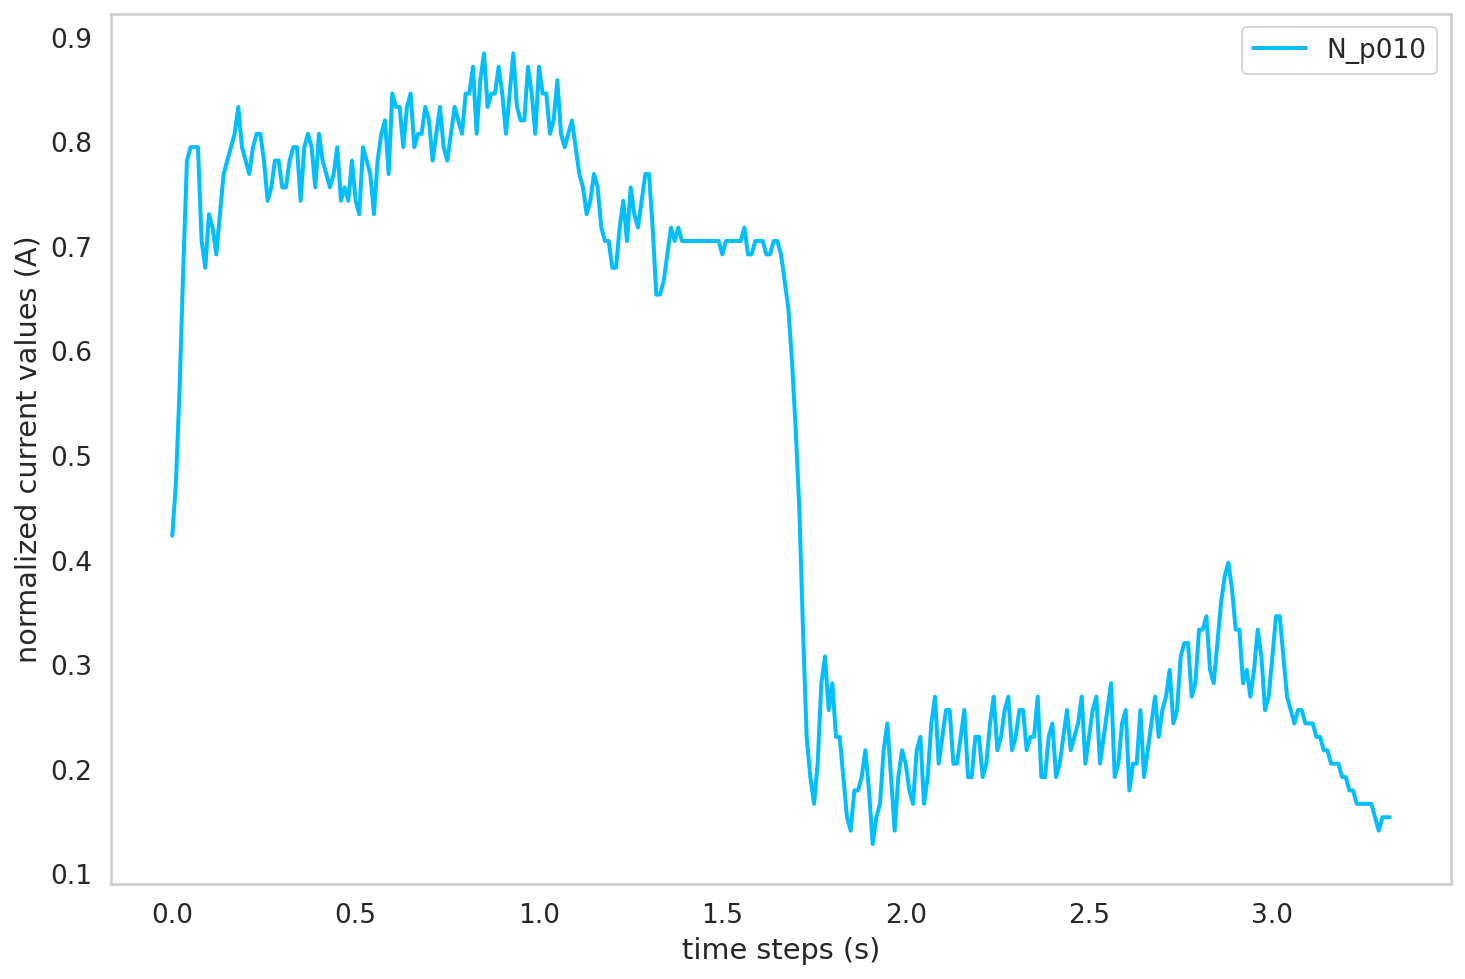

In [ ]:
lineWidth = 2

# indexes, values = prepare_axies(raw_N_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='N', lw=lineWidth)

# indexes, values = prepare_axies(raw_025_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='L025', lw=lineWidth)

# indexes, values = prepare_axies(raw_050_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='L050', lw=lineWidth)

# indexes, values = prepare_axies(raw_075_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='L075', lw=lineWidth)

# indexes, values = prepare_axies(raw_100_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='L100', lw=lineWidth)

# indexes, values = prepare_axies(raw_N_p005_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='N_p005', lw=lineWidth)

indexes, values = prepare_axies(raw_N_p010_df.iloc[0,:-1], sampling_frequency)
plt.plot(indexes, values, label='N_p010', lw=lineWidth)

# indexes, values = prepare_axies(raw_N_p015_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='N_p015', lw=lineWidth)


plt.grid(b=None) 
plt.legend()
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
plt.show()

分割，只有p是单信号，其他的按照原来的分

In [ ]:
intervall = 160*2
start1 = 160

start_pos_base = [start1, start1+intervall, start1+intervall*2, start1+intervall*3]

start_pos_deviation = {
  'N': [0,0,0,0,0,
      0,0,0,0,0,
      0,0,0,0,0,
      0,0,0,0,0,
      0,0,0,0,0,
      0,0,0,0,0],
  'L005': [0,0,0,0,0,
        0,0,0,0,0,
        0,0,0,0,0,
        0,0,0,0,0],
  'L010': [0,0,0,0,0,
        0,0,0,0,0,
        0,0,0,0,0,
        0,0,0,0,0],
  'L015': [0,0,0,0,0,
        0,0,0,0,0,
        0,0,0,0,0,
        0,0,0,0,0],
  'L020': [0,0,0,0,0,
        0,0,0,0,0,
        0,0,0,0,0,
        0,0,0,0,0],
  'L025': [0,0,0,0,0,
        0,0,0,0,0,
        0,0,0,0,0,
        0,0,0,0,0],
}

In [ ]:
def create_circle(data_name, normalized=True):
  raw_df = readRawData(data_name, normalized)
  target = raw_df.iloc[:,-1]
  res_df = pd.DataFrame()

  fore_interval = 160
  back_interval = 160

  for i in range(len(start_pos_deviation[data_name])): # 每种的四周期原始数据个数
    for j in range(len(start_pos_base)): #每条原始数据的四条circle
      cur = raw_df.iloc[i, start_pos_base[j]+start_pos_deviation[data_name][i]-fore_interval : start_pos_base[j]+start_pos_deviation[data_name][i]+back_interval].reset_index(drop=True).T
      res_df = res_df.append(cur, ignore_index=True)

  target = pd.DataFrame(data=raw_df.iloc[0,-1], index=range(len(res_df)), columns=range(1))
  res_df = pd.concat([res_df,target],axis = 1, ignore_index= True)

  # res_df = res_df.sample(frac=1.0)
  res_df.reset_index(drop=True, inplace=True)
  return res_df

In [ ]:
real_005_df = create_circle('L005', normalized=True)
real_010_df = create_circle('L010', normalized=True)
real_015_df = create_circle('L015', normalized=True)
real_020_df = create_circle('L020', normalized=True)
real_025_df = create_circle('L025', normalized=True)
real_N_df = create_circle('N', normalized=True)

raw_N_p005_df = readRawData('N_p005', normalized=True)
raw_N_p010_df = readRawData('N_p010', normalized=True)
raw_N_p015_df = readRawData('N_p015', normalized=True)

Guess

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

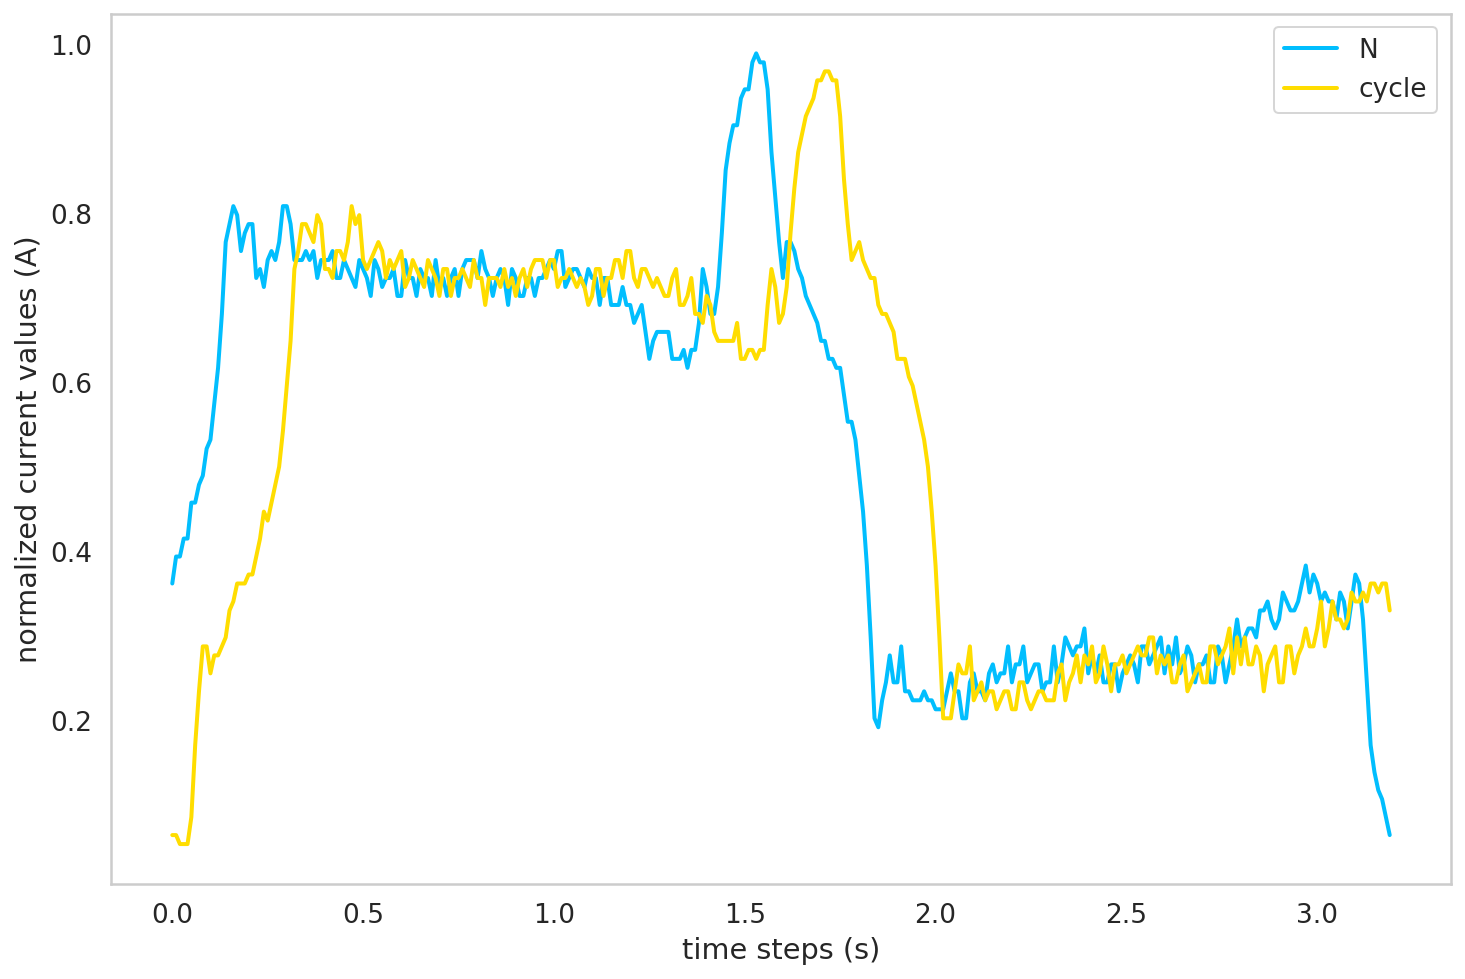

In [ ]:
# indexes, values = prepare_axies(raw_N_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='RAW', lw=lineWidth)

indexes, values = prepare_axies(real_N_df.iloc[0,:-1], sampling_frequency)
plt.plot(indexes, values, label='N', lw=lineWidth)

indexes, values = prepare_axies(real_N_df.iloc[1,:-1], sampling_frequency)
plt.plot(indexes, values, label='cycle', lw=lineWidth)

# indexes, values = prepare_axies(raw_N_p005_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='N_p005', lw=lineWidth)

# indexes, values = prepare_axies(raw_N_p010_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='N_p010', lw=lineWidth)

# indexes, values = prepare_axies(raw_N_p015_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='N_p015', lw=lineWidth)

plt.grid(b=None) 
plt.legend()
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
plt.show()

In [ ]:
test_df = pd.read_csv('drive/MyDrive/dataset/MA_1D/N_300to400_s100_p0.05/N_300to400_p0.05_s100_01.csv', header=None)

ParserError: ignored

<Figure size 960x720 with 0 Axes>

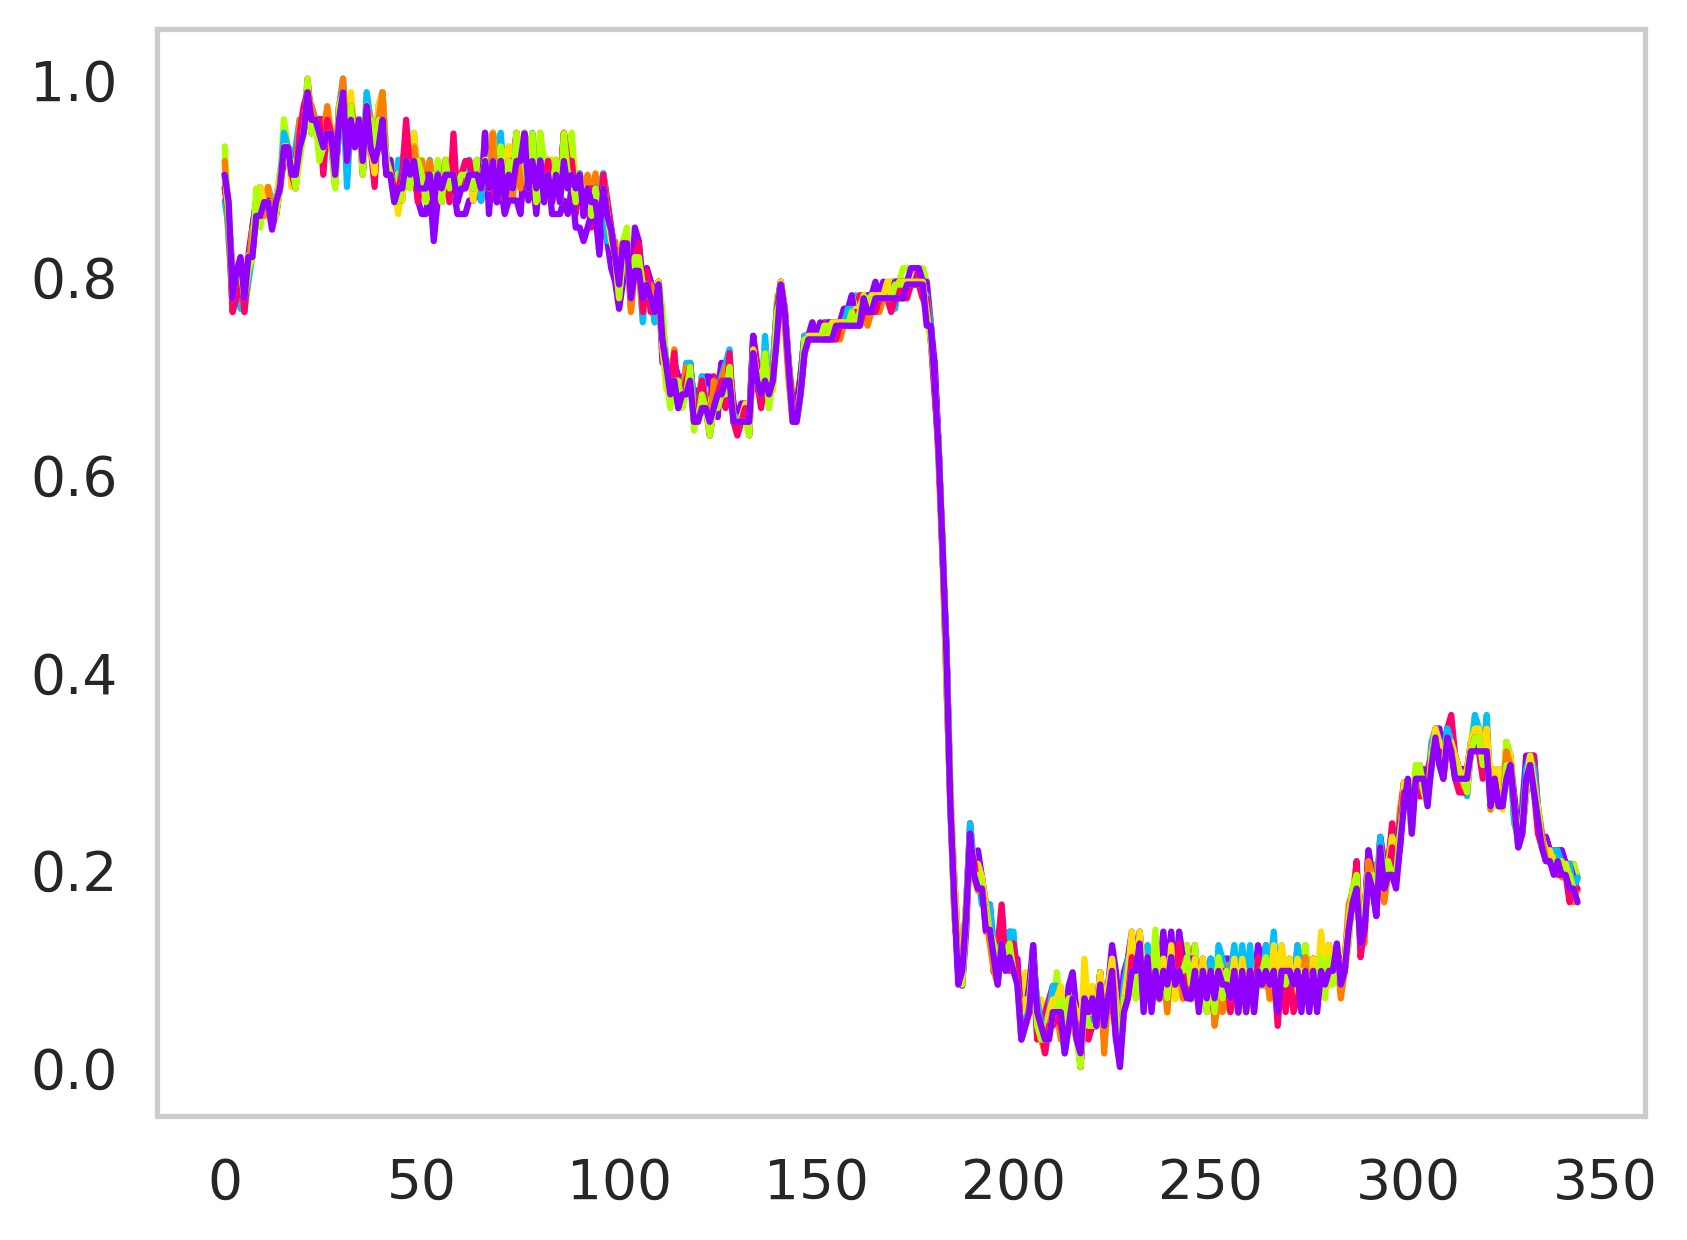

In [ ]:
# normal condition
plt.figure(dpi=150, figsize=plt.rcParamsDefault["figure.figsize"])
plt.grid(None)

for i in range(len(N_df)):
  plt.plot(N_df.iloc[i,:-1])

<Figure size 960x720 with 0 Axes>

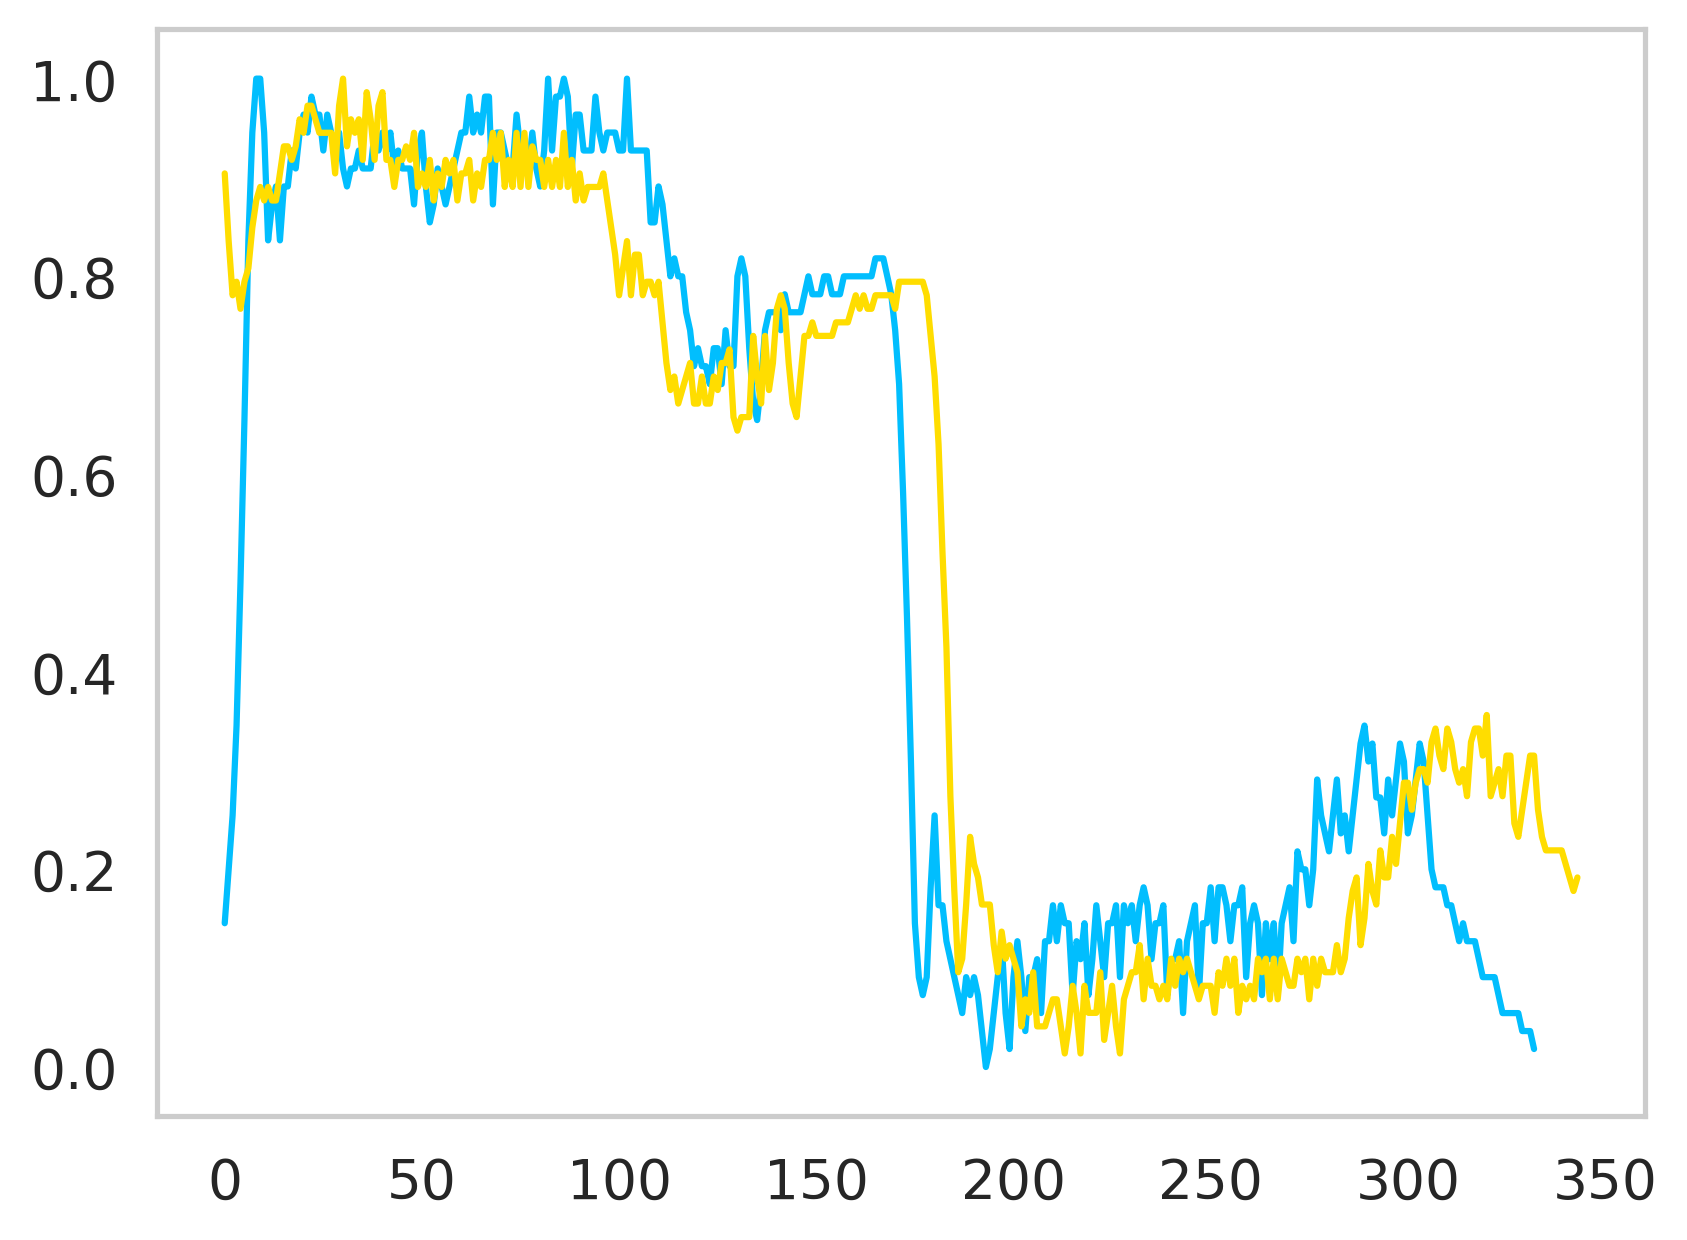

In [ ]:
plt.figure(dpi=150, figsize=plt.rcParamsDefault["figure.figsize"])
plt.grid(None)

plt.plot(p005_df.iloc[0])
plt.plot(N_df.iloc[0,:-1])



# indexes = np.arange(0, 3.44, 0.01)


# end = start + 350*5
# indexes = df['time'].values[start:end]-df['time'].values[start]
# values = preprocessing.MinMaxScaler().fit_transform(df['values'].values[start:end].reshape(-1, 1)).reshape(-1)

<Figure size 960x720 with 0 Axes>

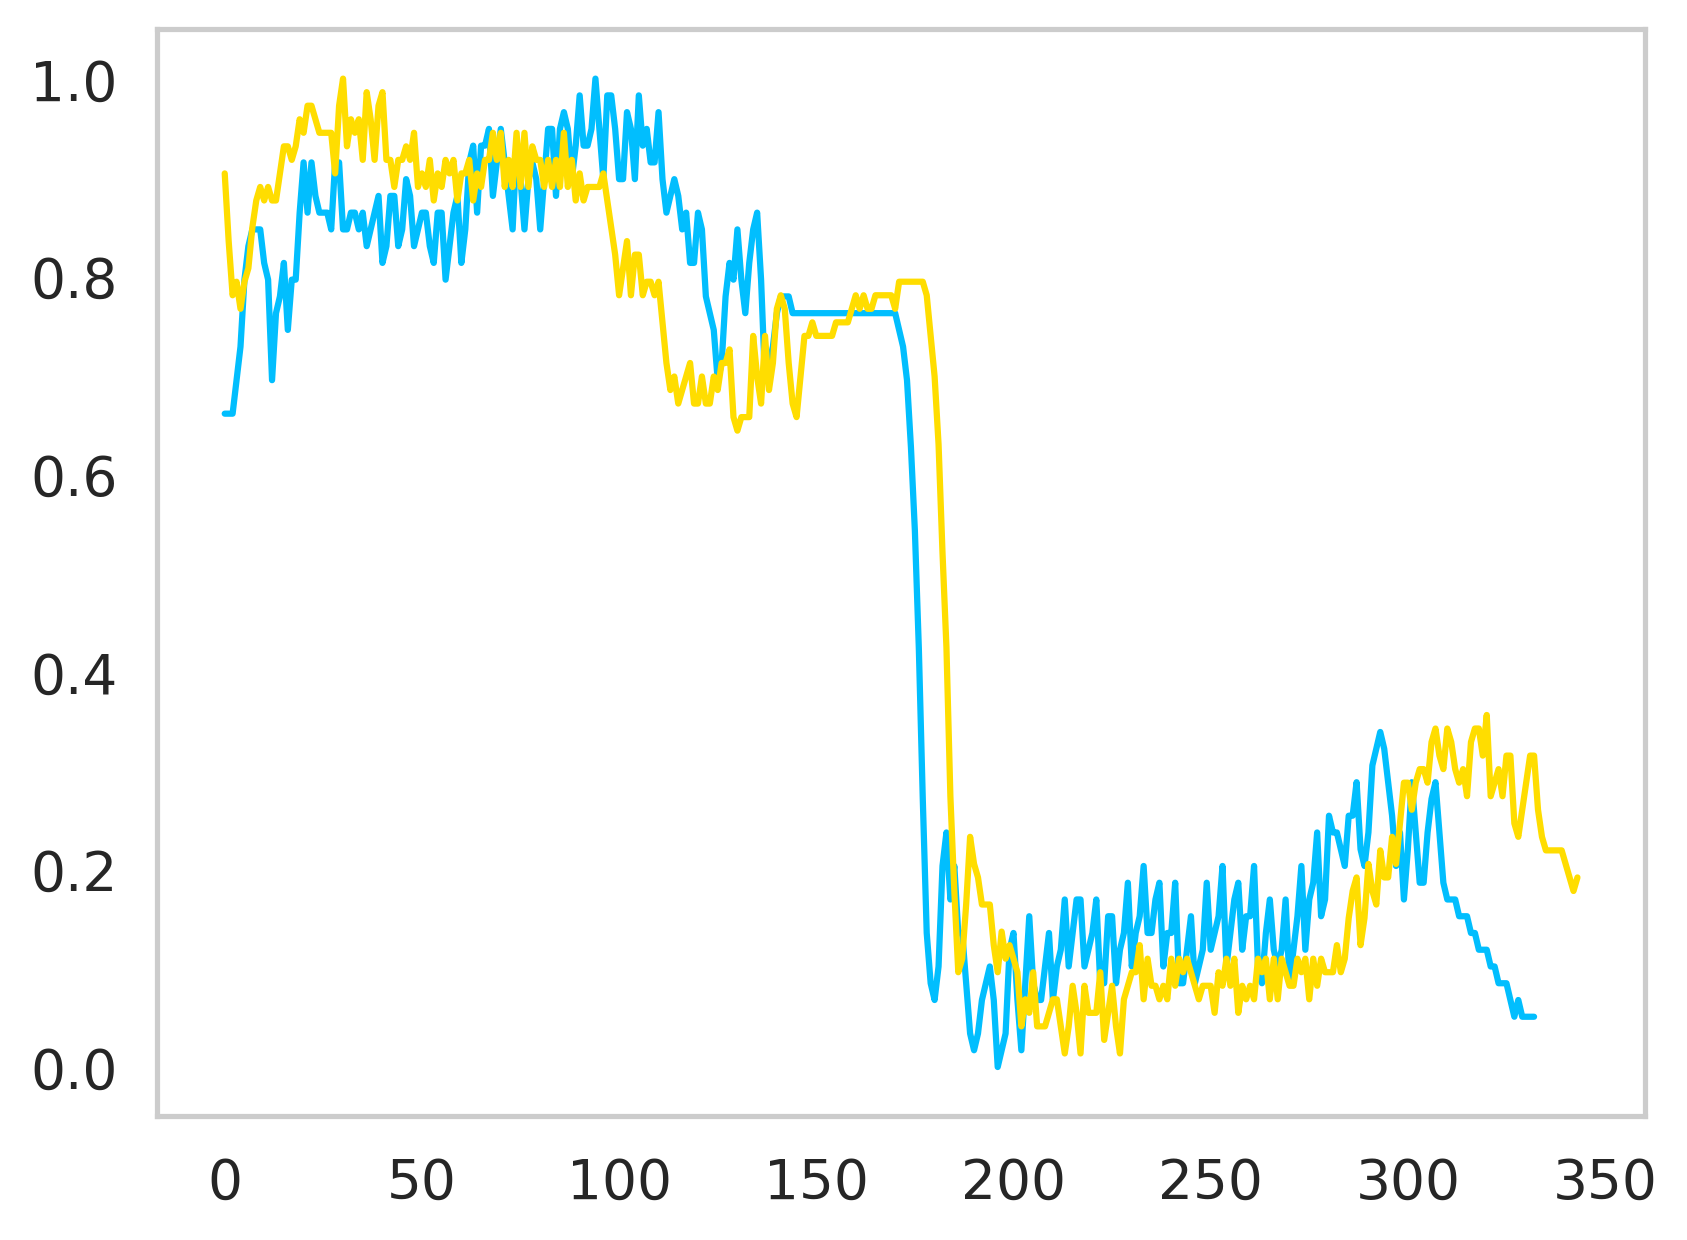

In [ ]:
plt.figure(dpi=150, figsize=plt.rcParamsDefault["figure.figsize"])
plt.grid(None)

plt.plot(p010_df.iloc[0])
plt.plot(N_df.iloc[0,:-1])

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

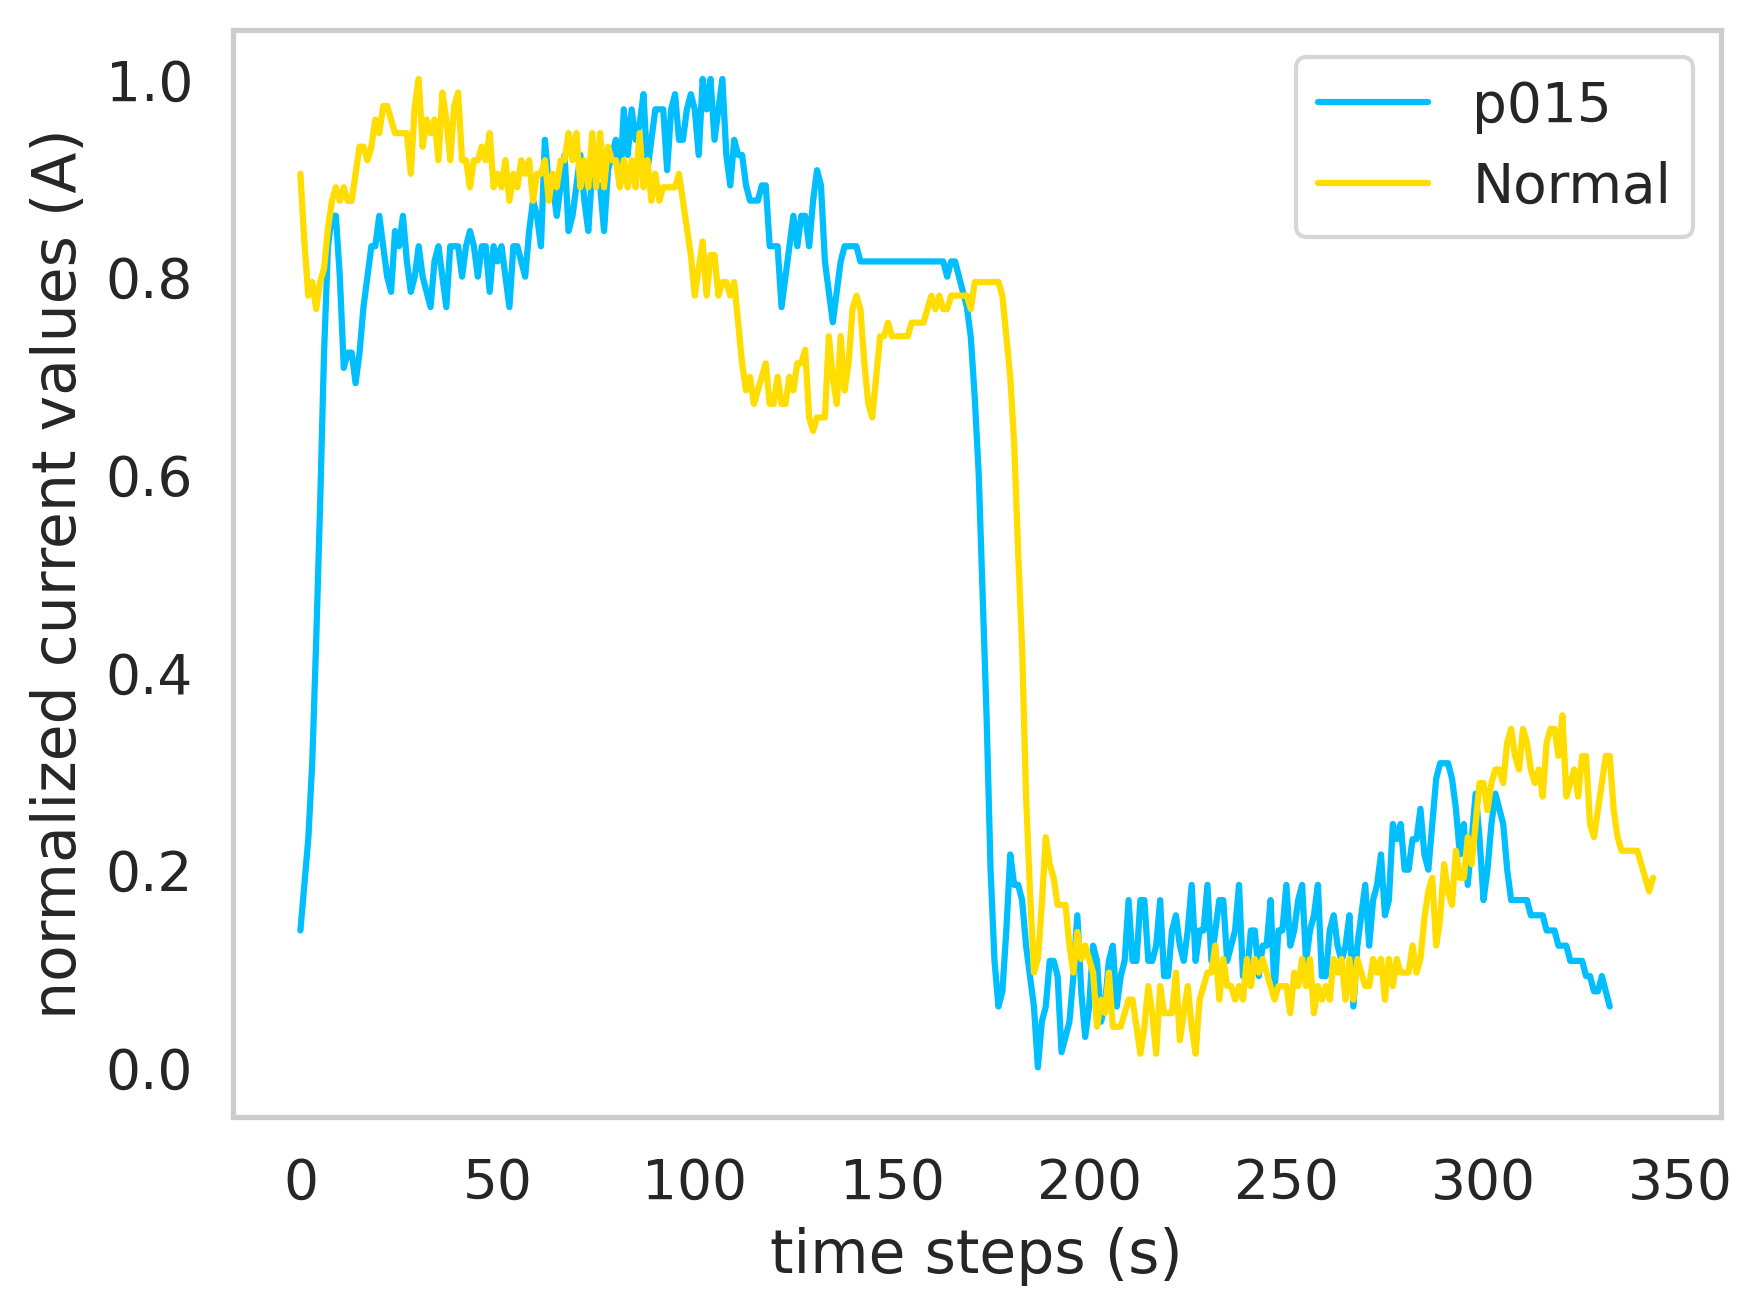

In [ ]:
plt.figure(dpi=150, figsize=plt.rcParamsDefault["figure.figsize"])
# lineWidth = 0.75

plt.plot(p015_df.iloc[0], label='p015')
plt.plot(N_df.iloc[0,:-1], label='Normal')

plt.grid(None)
plt.legend()
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
# plt.title(' compare data')
plt.show()

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

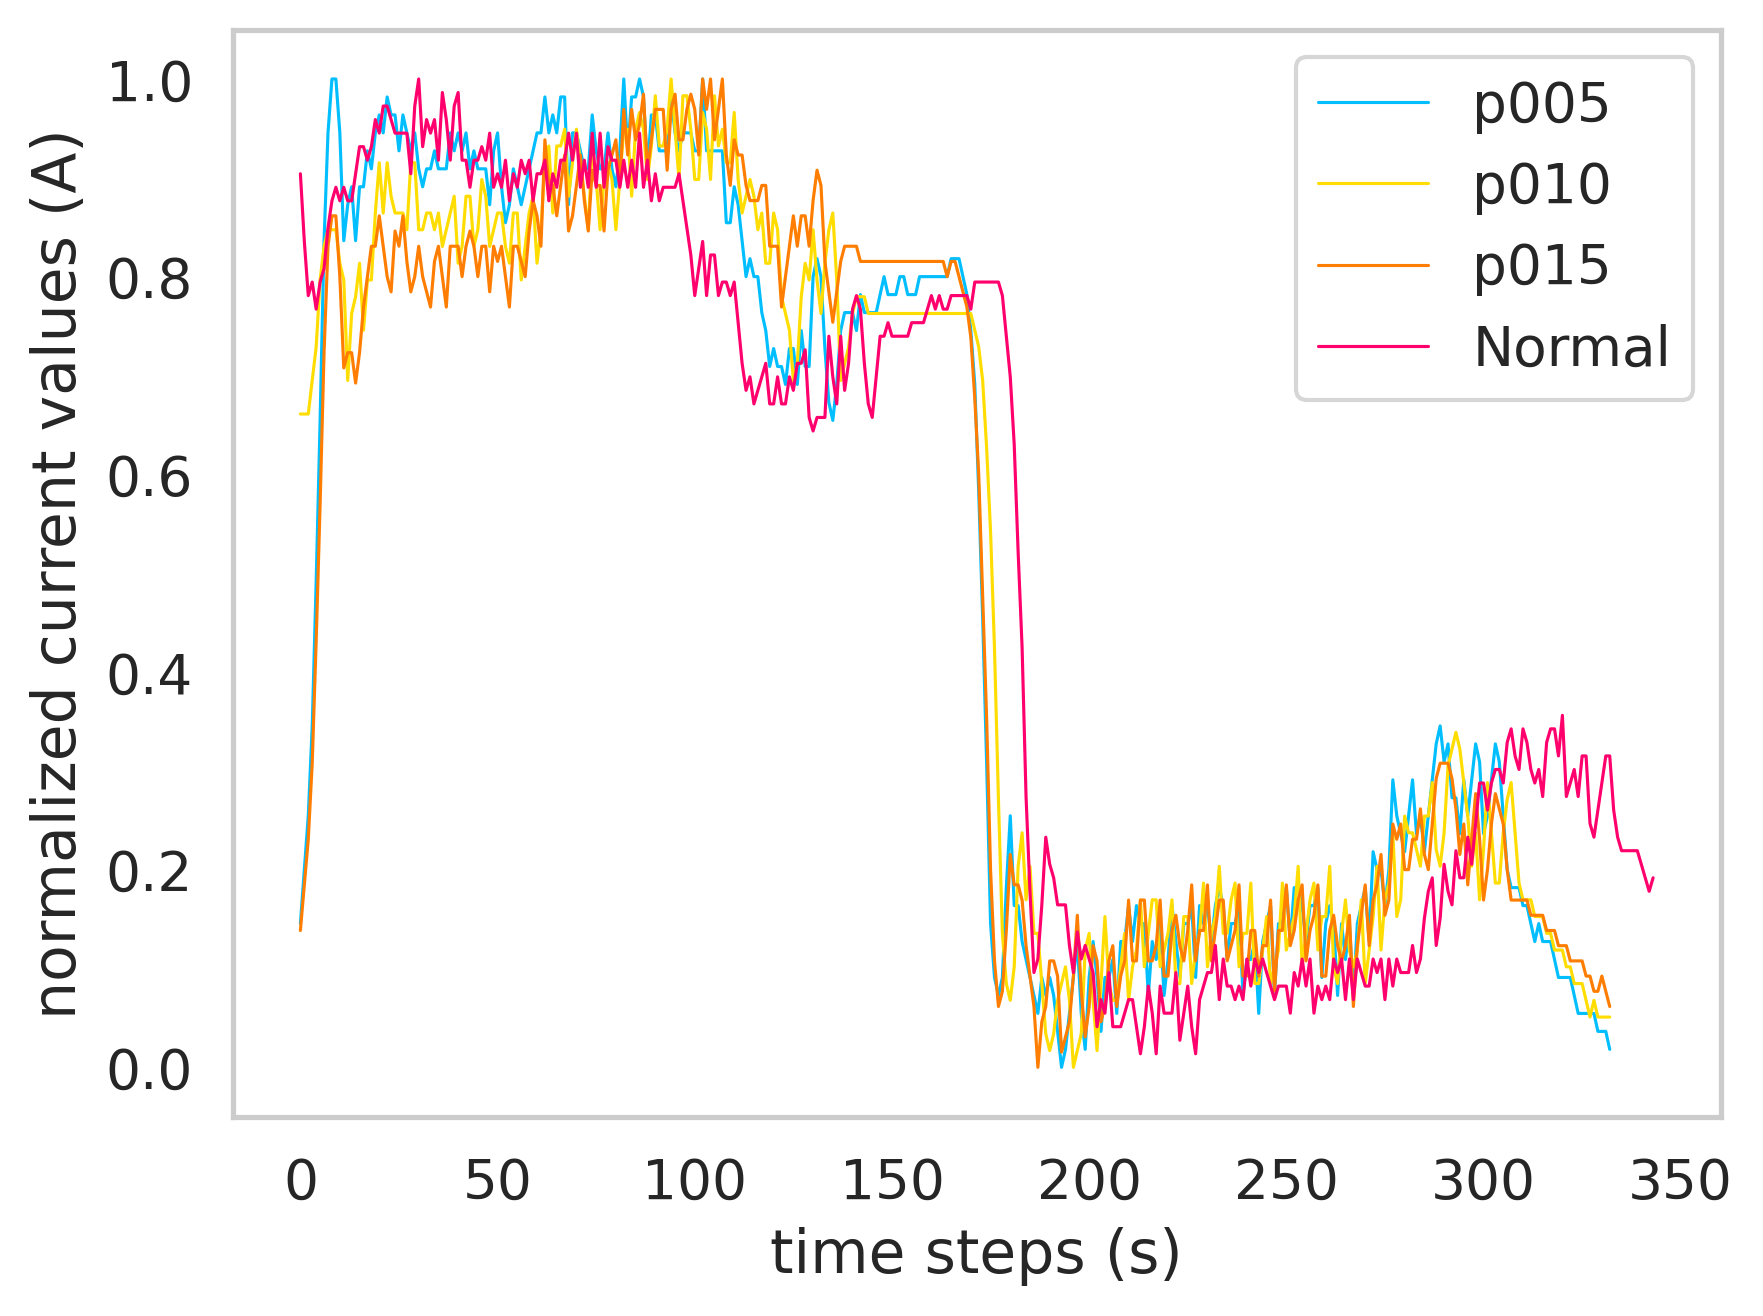

In [ ]:
plt.figure(dpi=150, figsize=plt.rcParamsDefault["figure.figsize"])
lineWidth = 0.75

plt.plot(p005_df.iloc[0], label='p005', lw = lineWidth)
plt.plot(p010_df.iloc[0], label='p010', lw = lineWidth)
plt.plot(p015_df.iloc[0], label='p015', lw = lineWidth)
plt.plot(N_df.iloc[0,:-1], label='Normal', lw = lineWidth)

plt.grid(None)
plt.legend()
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
# plt.title(' compare data')
plt.show()

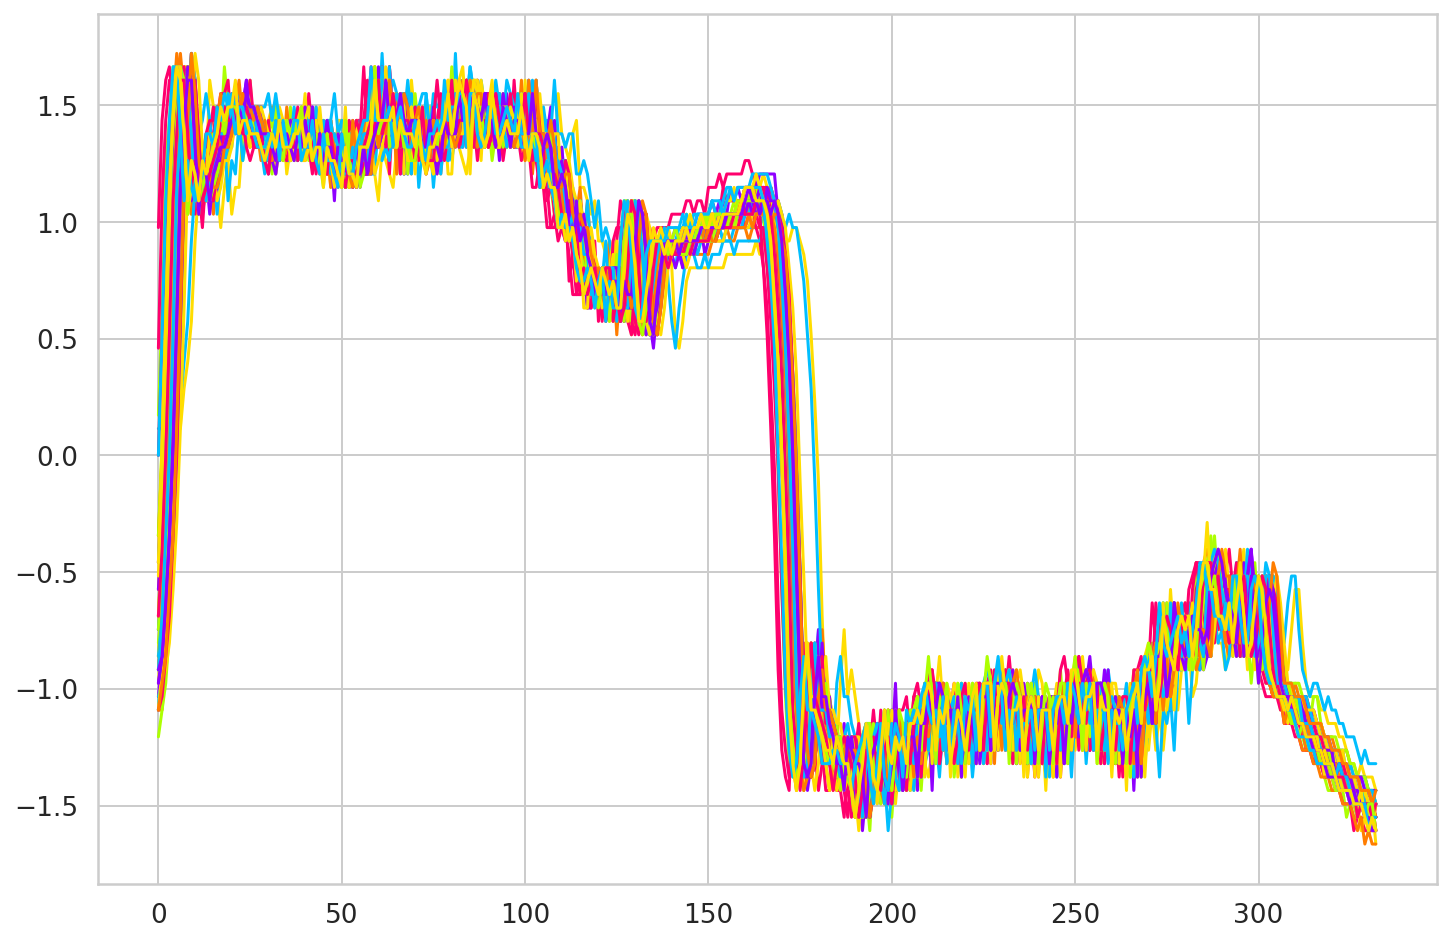

In [ ]:
# p005 force-change
for i in range(len(p005_df)):
  plt.plot(p005_df.iloc[i])

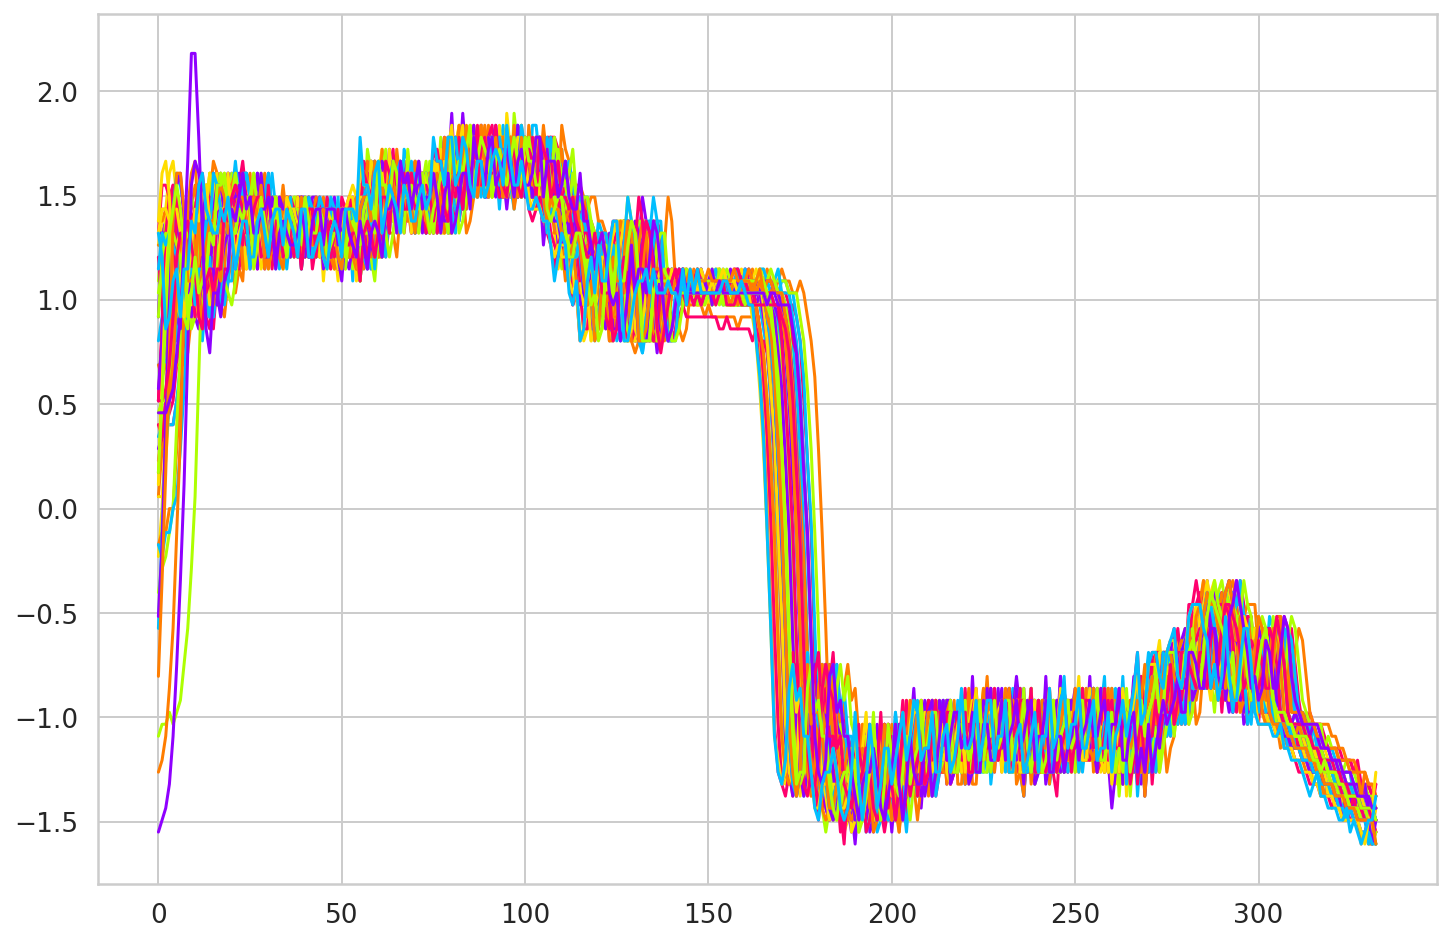

In [ ]:
# p010 force-change
for i in range(len(p010_df)):
  plt.plot(p010_df.iloc[i])

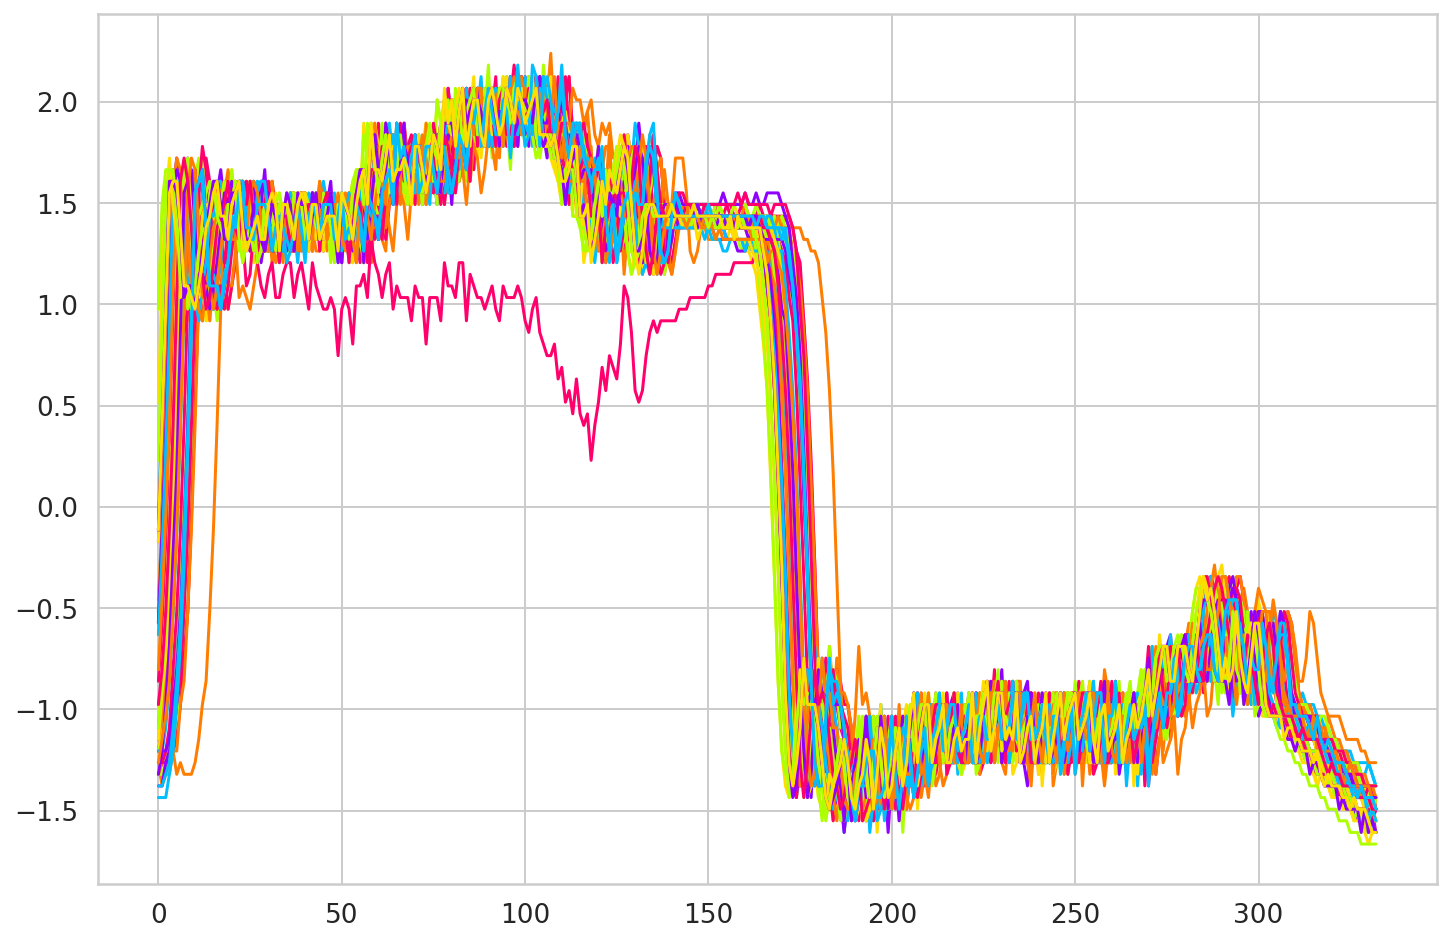

In [ ]:
# p015 force-change
for i in range(len(p015_df)):
  plt.plot(p015_df.iloc[i])

In [ ]:
len(p005_df.iloc[0].values)

333